#### output weights n layer,  validation set, graph plot, test set, lstm cell stack, preloaded full data before training, fetch data from another notebook, added exection time of 1 epoch and remaining time, training with mini batches.

In [1]:
from sklearn import metrics
import tensorflow as tf
#import csv
#from threading import Thread
import time
from matplotlib import pyplot as plt
from  read_proces_data import *

In [2]:
# hidden units for lstm
hidden_units = 64
# Lstm layers
num_layers = 1
# chunks of input given to lstm at a time for training
batch_size = 64
# max seq length in training and test data
max_seq = 3260
# input dimension
feature_vec_len = 57

In [3]:
# find max no of times to roll back
#max_seq_len = find_max_seq_len()
#print max_seq_len
max_seq_len = 3259

In [4]:
# use ipython feature to read data from another notebook
% store -r inde_featuress
% store -r sseq_len
% store -r target_valuess

In [5]:
train_batch = np.zeros((5440,3260,57),dtype=np.float32)
seq_batch = np.zeros(0)
target_batch = np.zeros(0)

In [6]:
current_i = 0
for i in range(len(inde_featuress)):
    file_len = inde_featuress[i].shape[0]
    seq_batch = np.append(seq_batch,sseq_len[i])
    target_batch = np.append(target_batch,target_valuess[i])
    for j in range(file_len):
        train_batch[current_i+j] = inde_featuress[i][j]
    current_i += file_len

In [7]:
del inde_featuress
del sseq_len
del target_valuess

In [8]:
sess = tf.InteractiveSession()

In [9]:
# create lstm cell in tensorflow
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(num_units =\
        hidden_units,state_is_tuple=True)
stacked_cell = tf.contrib.rnn.MultiRNNCell(\
        [lstm_cell() for _ in range(num_layers)], \
        state_is_tuple=True)

In [10]:
x = tf.placeholder(tf.float32, shape = [batch_size,max_seq,feature_vec_len])
s_len = tf.placeholder(tf.int32,shape=[batch_size])
# run lstm over different sequence length
output_, state = tf.nn.dynamic_rnn(\
        stacked_cell,\
        x,\
#        initial_state = i_state,\
        sequence_length=s_len,\
        dtype=tf.float32)
# take all batch, last output of each batch and full output vector
def take_subarray(array , index):
    return array[range(0,batch_size),index-1]
output = tf.py_func(take_subarray,[output_,s_len],tf.float32)
#print output
# define final output value
target_value = tf.placeholder(tf.float32, shape=[batch_size])
# define weights and bias from output of lstm cell to network final output
output_size = stacked_cell.output_size
std = 1/np.sqrt(feature_vec_len,dtype=np.float32)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=std,dtype=tf.float32)
    return tf.Variable(initial,dtype=tf.float32)

def bias_variable(shape):
    initial = tf.constant(std, shape=shape,dtype=tf.float32)
    return tf.Variable(initial,dtype=tf.float32)

Wo1 = weight_variable([output_size, 2 * output_size])
Wo2 = weight_variable([2*output_size, 2 * output_size])
Wo3 = weight_variable([2*output_size, 2 * output_size])
Wo4 = weight_variable([2*output_size, 1])

b1 = bias_variable([2 * output_size])
b2 = bias_variable([2 * output_size])
b3 = bias_variable([2 * output_size])
b4 = bias_variable([1])

# initialize variables
# calculate final output

s1  = tf.matmul(output, Wo1) + b1
o1 = tf.nn.relu(s1)

s2  = tf.matmul(o1, Wo2) + b2
o2 = tf.nn.relu(s2)

s3  = tf.matmul(o2, Wo3) + b3
o3 = tf.nn.relu(s3)

logits  = tf.matmul(o3, Wo4) + b4
observed = tf.sigmoid(logits)
#observed = tf.nn.relu(logits)

# calculate cost as calculated in logistic classification.
logistic_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels = tf.reshape(target_value,[batch_size,1]), logits = logits))

# optimize the cost
train_step = tf.train.AdamOptimizer(1e-4).minimize(logistic_cost)

def threshold_fn(array):
    return array >= 0.50
obser = tf.py_func(threshold_fn,[observed], tf.bool)
observe = tf.cast(obser,tf.float32)

sess.run(tf.global_variables_initializer())

In [11]:
def calc_metrics(t,y):
    
    f1score = metrics.f1_score(t,y)
    
    fprr, tprr, thresholds = metrics.roc_curve(t, y, pos_label=1)
    aucc = metrics.auc(fprr,tprr)
    
    sk_acc = metrics.accuracy_score(t,y)
    
    return (f1score, aucc, sk_acc)

In [12]:
def evaluate_(data):
    # evaluate on all last 5000 values but
    # take only last validation set values
    y = sess.run(observe, feed_dict = {\
        x:data[0], s_len:data[1]})

    c = sess.run(logistic_cost, feed_dict = {target_value:data[2],\
        x:data[0], s_len:data[1]})
    
    f1s,auc,acc = calc_metrics(data[2],y)
    
    epoch_para.append([f1s, auc, acc, c])

In [13]:
def train_(data):
    # train on training data-set
    sess.run(train_step, feed_dict = {target_value:data[2],\
            x:data[0], s_len:data[1]})

In [ ]:
def plot_parameters(training_p, validation_p):
    nu_para = training_p.shape[1]
    para_name = ['f1score','auc','accuracy','cost']
    for j in range(nu_para):
        plt.subplot(nu_para,1,j+1)
        plt.plot(training_p[:,j],'r')
        plt.plot(validation_p[:,j],'b')
        plt.ylabel(para_name[j])
        plt.grid()
    plt.show()

iteration 0
training cost: 0.589289
validation cost: 0.783935
time(in minutes) for 100 iter 4.059786
remaining time(in minutes) 202.948677


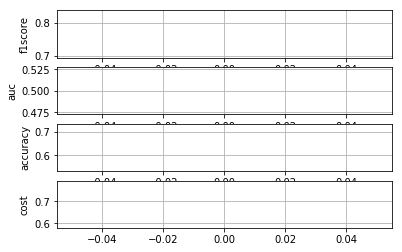

iteration 100
training cost: 0.586276
validation cost: 0.763713
time(in minutes) for 100 iter 129.971166
remaining time(in minutes) 6367.287420


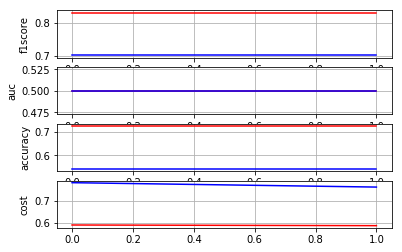

In [ ]:
# number of times to iterate over whole training dataset    
epochs =  5000
# train_para and vali_para are storing f1score,auc,accuracy for 
# train and validation set.
train_para = []
vali_para = []
epoch_para = []

val_size = 512
train_size = 5440-val_size

now_time = time.time()
for itera in range(0, epochs):
    # train on full training data set
    for index in range(0,train_size,batch_size):
        end = index+batch_size
        train_data = [train_batch[index:end], seq_batch[index:end], target_batch[index:end]]
        train_(train_data)
        
    if 0==itera%100:        
        # evaluate on train data
        for index in range(0,train_size,batch_size):
            end = index+batch_size
            train_data = [train_batch[index:end], seq_batch[index:end], target_batch[index:end]]
            evaluate_(train_data)
        epoch_para = np.asarray(epoch_para)
        train_para.append(np.mean(epoch_para,axis=0))
        epoch_para = []
        # evaluate on validation data
        for index in range(train_size,5440,batch_size):
            end = index+batch_size
            val_data = [train_batch[index:end], seq_batch[index:end], target_batch[index:end]]
            evaluate_(val_data)
        epoch_para = np.asarray(epoch_para)
        vali_para.append(np.mean(epoch_para,axis=0))
        epoch_para = []
            
        print "iteration %d"%itera
        print "training cost: %f"%train_para[-1][-1]
        print "validation cost: %f"%vali_para[-1][-1]
        
        time_taken = (time.time()-now_time)/60.0
        print "time(in minutes) for 100 iter %f"%(time_taken)
        print "remaining time(in minutes) %f"%((time_taken/100.0)*(epochs-1-itera))
        now_time = time.time()
        
        t_para = np.asarray(train_para)
        v_para = np.asarray(vali_para)

        plot_parameters(t_para, v_para)

In [ ]:
del train_batch
del seq_batch
del target_batch

In [ ]:
max_seq_len = 3259
test_feature = []
test_seq = []
def data_processing(file_name):
    # get features from current indexed file
    features = get_test_data(file_name)
    # get target values corresponding to this file
    #target_valuess.append(get_target_values(file_name))
    # training features is np array with max size and padding
    training_features, s_l = prepare_data(features, max_seq_len)
    test_seq.append(s_l)
    # scale features to have 0 mean and 1 variance
    scaled_features = feature_scaling(training_features, s_l)
    # find independent components from given features
    test_feature.append(independent_components(scaled_features, s_l))

In [ ]:
for file_ in test_file_dir:
    data_processing(file_)

In [ ]:
test_batch = np.zeros((3456,3260,57),dtype=np.float32)
test_seq_batch = np.zeros(0)
current_i = 0
for i in range(len(test_feature)):
    file_len = test_feature[i].shape[0]
    test_seq_batch = np.append(test_seq_batch,test_seq[i])
    #target_batch = np.append(target_batch,target_valuess[i])
    for j in range(file_len):
        test_batch[current_i+j] = test_feature[i][j]
    current_i += file_len

In [ ]:
del test_feature
del test_seq

In [ ]:
y_pred = np.zeros(0)
for index in range(0,3456,batch_size):
    end = index+batch_size
    y = sess.run(observe, feed_dict = {\
        x:test_batch[index:end],\
        s_len:test_seq_batch[index:end]})
    y_pred = np.append(y_pred, y)
del test_batch
del test_seq_batch
y_pred = np.append(y_pred,np.ones(56))

In [ ]:
# predict values for test data set
index = 0
print ('opening file for write')
label = ["IdFeedBack,Prediction"]
with open('output.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ')
    spamwriter.writerow(label)
    for file_ in test_file_dir:
        y = np.zeros(0)
        if "Sess05" in file_:
            indices = ["%03d" %(i+1) for i in range(100)]
        else:
            indices = ["%03d" %(i+1) for i in range(60)]

        for i in range(0,len(indices)):
            values = [file_[5:-4]+'_FB'+indices[i]+','+str(int(y_pred[index]))]
            index+=1
            spamwriter.writerow(values)
print ('file write complete')